First install google and xarray modules

In [2]:
!pip install xarray[viz] gcsfs zarr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import needed modules

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cftime
import time

### **Brows CMIP catalog**

use Pandas to read CSV file and print first lines

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv', low_memory=False)
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


Print variables, and experiments

In [5]:
from numpy.ma.core import exp
vars=df.variable_id.unique()
#vars=vars.sort()

exps=df.experiment_id.unique()
#exps=exps.sort()

print(exps)
print(vars)

['highresSST-present' 'piControl' 'control-1950' 'hist-1950' 'historical'
 'amip' 'abrupt-4xCO2' 'abrupt-2xCO2' 'abrupt-0p5xCO2' '1pctCO2' 'ssp585'
 'esm-piControl' 'esm-hist' 'hist-piAer' 'histSST-1950HC' 'ssp245'
 'hist-1950HC' 'histSST' 'piClim-2xVOC' 'piClim-2xNOx' 'piClim-2xdust'
 'piClim-2xss' 'piClim-histall' 'hist-piNTCF' 'histSST-piNTCF'
 'aqua-control-lwoff' 'piClim-lu' 'histSST-piO3' 'piClim-CH4'
 'piClim-NTCF' 'piClim-NOx' 'piClim-O3' 'piClim-HC' 'faf-heat-NA0pct'
 'ssp370SST-lowCH4' 'piClim-VOC' 'ssp370-lowNTCF' 'piClim-control'
 'piClim-aer' 'hist-aer' 'faf-heat' 'faf-heat-NA50pct' 'ssp370SST-lowNTCF'
 'ssp370SST-ssp126Lu' 'ssp370SST' 'ssp370pdSST' 'histSST-piAer'
 'piClim-ghg' 'piClim-anthro' 'faf-all' 'hist-nat' 'hist-GHG' 'ssp119'
 'piClim-histnat' 'piClim-4xCO2' 'ssp370' 'piClim-histghg'
 'highresSST-future' 'esm-ssp585-ssp126Lu' 'ssp126-ssp370Lu'
 'ssp370-ssp126Lu' 'land-noLu' 'histSST-piCH4' 'ssp126' 'esm-pi-CO2pulse'
 'amip-hist' 'piClim-histaer' 'amip-4xCO2' 'faf-

Find all ssp experiments and one ensabmle member, and variables pr and tas,and store them in seperate dataframes

In [6]:
df_tmp_tas=df[(df["experiment_id"].isin(['historical','ssp585','ssp245','ssp370','ssp126'])) & (df["variable_id"].isin(['tas'])) & (df["table_id"]=='Amon') & (df["member_id"]=='r1i1p1f1')]
df_tmp_tas
df_tmp_pr=df[(df["experiment_id"].isin(['historical','ssp585','ssp245','ssp370','ssp126'])) & (df["variable_id"].isin(['pr'])) & (df["table_id"]=='Amon') & (df["member_id"]=='r1i1p1f1')]
df_tmp_pr

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
2371,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp245,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
2471,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
6263,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
13391,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp370,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
15390,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
...,...,...,...,...,...,...,...,...,...,...,...
523672,ScenarioMIP,KIOST,KIOST-ESM,ssp585,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/s...,NaN,20210928
523673,ScenarioMIP,KIOST,KIOST-ESM,ssp245,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/s...,NaN,20210928
523674,ScenarioMIP,KIOST,KIOST-ESM,ssp126,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/s...,NaN,20210928
523675,CMIP,KIOST,KIOST-ESM,historical,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/KIOST/KIOST-ESM/historic...,NaN,20210928


## **Load Data**

In [7]:
# load Google cloud storage
gcs = gcsfs.GCSFileSystem(token='anon')

In [8]:
#store data to dictionary
dsall_tas={}
for ssp in ['historical','ssp585','ssp245','ssp370','ssp126']:
  dsall_tas[ssp] = {}
#this is a loop through all of the 'zstore' values in the dataframe - which are the links to the stored data files
for index, (df_index,item) in enumerate(df_tmp_tas.iterrows(), start=0):
        zstore = item.zstore
        print('Link '+str(index)+': '+zstore)
        #the mapper is the function which retrieves the link (zstore element)
        mapper=gcs.get_mapper(zstore)
        #now we call xarray to open the mapper and make a new dataframe
        dstmp=xr.open_zarr(mapper)
        #and we add this to  a dictionary of xarray dataframes
        dsall_tas[item.experiment_id][item.source_id] = dstmp


Link 0: gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp585/r1i1p1f1/Amon/tas/gr1/v20180701/
Link 1: gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp245/r1i1p1f1/Amon/tas/gr1/v20180701/
Link 2: gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/
Link 3: gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp370/r1i1p1f1/Amon/tas/gr1/v20180701/
Link 4: gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp245/r1i1p1f1/Amon/tas/gr1/v20180701/
Link 5: gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp126/r1i1p1f1/Amon/tas/gr1/v20180701/
Link 6: gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Amon/tas/gr1/v20180701/
Link 7: gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr/v20180803/
Link 8: gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f1/Amon/tas/gn/v20180827/
Link 9: gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/tas/gn/v20181126/
Link 10: gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historic

/usr/local/lib/python3.7/dist-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.7/dist-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/usr/local/lib/python3.7/dist-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time 

Link 180: gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp126/r1i1p1f1/Amon/tas/gn/v20210317/
Link 181: gs://cmip6/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp126/r1i1p1f1/Amon/tas/gn/v20210318/


/usr/local/lib/python3.7/dist-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.7/dist-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/usr/local/lib/python3.7/dist-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time 

Link 182: gs://cmip6/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r1i1p1f1/Amon/tas/gn/v20210318/
Link 183: gs://cmip6/CMIP6/CMIP/KIOST/KIOST-ESM/historical/r1i1p1f1/Amon/tas/gr1/v20210601/
Link 184: gs://cmip6/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/ssp245/r1i1p1f1/Amon/tas/gr1/v20210601/
Link 185: gs://cmip6/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/ssp126/r1i1p1f1/Amon/tas/gr1/v20210601/
Link 186: gs://cmip6/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/ssp585/r1i1p1f1/Amon/tas/gr1/v20210601/
Link 187: gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/Amon/tas/gr/v20211207/


In [9]:
#load pr data
#store data to dictionary
dsall_pr={}
for ssp in ['historical','ssp585','ssp245','ssp370','ssp126']:
  dsall_pr[ssp] = {}
#this is a loop through all of the 'zstore' values in the dataframe - which are the links to the stored data files
for index, (df_index,item) in enumerate(df_tmp_pr.iterrows(), start=0):
        zstore = item.zstore
        print('Link '+str(index)+': '+zstore)
        #the mapper is the function which retrieves the link (zstore element)
        mapper=gcs.get_mapper(zstore)
        #now we call xarray to open the mapper and make a new dataframe
        dstmp=xr.open_zarr(mapper)
        #and we add this to  a dictionary of xarray dataframes
        dsall_pr[item.experiment_id][item.source_id] = dstmp

Link 0: gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp245/r1i1p1f1/Amon/pr/gr1/v20180701/
Link 1: gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp585/r1i1p1f1/Amon/pr/gr1/v20180701/
Link 2: gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/pr/gr1/v20180701/
Link 3: gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp370/r1i1p1f1/Amon/pr/gr1/v20180701/
Link 4: gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp245/r1i1p1f1/Amon/pr/gr1/v20180701/
Link 5: gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp126/r1i1p1f1/Amon/pr/gr1/v20180701/
Link 6: gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Amon/pr/gr1/v20180701/
Link 7: gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/pr/gr/v20180803/
Link 8: gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f1/Amon/pr/gn/v20180827/
Link 9: gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/pr/gn/v20181126/
Link 10: gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f

/usr/local/lib/python3.7/dist-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.7/dist-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


Link 84: gs://cmip6/CMIP6/ScenarioMIP/NIMS-KMA/KACE-1-0-G/ssp585/r1i1p1f1/Amon/pr/gr/v20190920/
Link 85: gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/pr/gr/v20190927/
Link 86: gs://cmip6/CMIP6/ScenarioMIP/NIMS-KMA/KACE-1-0-G/ssp126/r1i1p1f1/Amon/pr/gr/v20191007/
Link 87: gs://cmip6/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/ssp245/r1i1p1f1/Amon/pr/gr/v20191013/
Link 88: gs://cmip6/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/ssp585/r1i1p1f1/Amon/pr/gr/v20191013/
Link 89: gs://cmip6/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/ssp370/r1i1p1f1/Amon/pr/gr/v20191013/
Link 90: gs://cmip6/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/ssp126/r1i1p1f1/Amon/pr/gr/v20191013/
Link 91: gs://cmip6/CMIP6/CMIP/UA/MCM-UA-1-0/historical/r1i1p1f1/Amon/pr/gn/v20191017/
Link 92: gs://cmip6/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ssp126/r1i1p1f1/Amon/pr/gn/v20191108/
Link 93: gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-LM/ssp245/r1i1p1f1/Amon/pr/gn/v20191108/
Link 94: gs://cmip6/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ssp585/r1i1p1f1/Amon/pr/gn/v2

/usr/local/lib/python3.7/dist-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.7/dist-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/usr/local/lib/python3.7/dist-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time 

Link 180: gs://cmip6/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp126/r1i1p1f1/Amon/pr/gn/v20210318/
Link 181: gs://cmip6/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r1i1p1f1/Amon/pr/gn/v20210318/
Link 182: gs://cmip6/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/ssp585/r1i1p1f1/Amon/pr/gr1/v20210928/
Link 183: gs://cmip6/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/ssp245/r1i1p1f1/Amon/pr/gr1/v20210928/
Link 184: gs://cmip6/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/ssp126/r1i1p1f1/Amon/pr/gr1/v20210928/
Link 185: gs://cmip6/CMIP6/CMIP/KIOST/KIOST-ESM/historical/r1i1p1f1/Amon/pr/gr1/v20210928/
Link 186: gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/Amon/pr/gr/v20211207/


### Plot example data

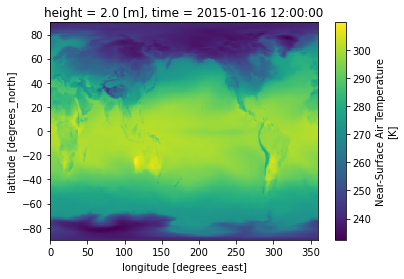

In [10]:
dsall_tas['ssp126']['GFDL-ESM4'].isel(time=0).tas.plot()

## Next Calculate global and some regional means

In [11]:
#define function for calculating area weighted means

def calcMean(data):

    #unfortunatly not all models use lat/lon naming... fixing this
    if ('longitude' in data.dims) and ('latitude' in data.dims):
        data = data.rename({'longitude':'lon', 'latitude': 'lat'})

    weights = np.cos(np.deg2rad(data.lat))
    data_weighted = data.weighted(weights)
    return data_weighted.mean(("lon", "lat"),skipna=True)

Icon model has weird grid fix that, runing this is good time to get coffee

> Indented block



In [12]:
#define list of tas and pr list
ds_list_all ={"tas":dsall_tas,"pr":dsall_pr}

mean_ds={'pr':{},'tas':{}}

for variable,dslist in ds_list_all.items():
    for exp,model_list in dslist.items():
        list_of_model_names=[]
        list_of_means=[]
        for model_name,model_data in model_list.items():
            print('MODEL: ',model_name,"Variable: ",variable," Experiment: ",exp)
            if model_name == "ICON-ESM-LR": #skip ICON model due to not lan/lon grid
                continue
            list_of_model_names.append(model_name)
            list_of_means.append(calcMean(model_data)[variable].groupby('time.year').mean())
        mean_ds[variable][exp] = xr.concat(list_of_means, pd.Index(list_of_model_names, name="source_id"),coords="minimal")

MODEL:  GFDL-CM4 Variable:  tas  Experiment:  historical
MODEL:  IPSL-CM6A-LR Variable:  tas  Experiment:  historical
MODEL:  GISS-E2-1-G Variable:  tas  Experiment:  historical
MODEL:  BCC-CSM2-MR Variable:  tas  Experiment:  historical
MODEL:  MIROC6 Variable:  tas  Experiment:  historical
MODEL:  BCC-ESM1 Variable:  tas  Experiment:  historical
MODEL:  MRI-ESM2-0 Variable:  tas  Experiment:  historical
MODEL:  CESM2-WACCM Variable:  tas  Experiment:  historical
MODEL:  CESM2 Variable:  tas  Experiment:  historical
MODEL:  SAM0-UNICON Variable:  tas  Experiment:  historical
MODEL:  GISS-E2-1-H Variable:  tas  Experiment:  historical
MODEL:  CanESM5 Variable:  tas  Experiment:  historical
MODEL:  INM-CM4-8 Variable:  tas  Experiment:  historical
MODEL:  INM-CM5-0 Variable:  tas  Experiment:  historical
MODEL:  MPI-ESM-1-2-HAM Variable:  tas  Experiment:  historical
MODEL:  NESM3 Variable:  tas  Experiment:  historical
MODEL:  CAMS-CSM1-0 Variable:  tas  Experiment:  historical
MODEL: 

Let's see what we have

In [13]:
mean_ds['tas']['ssp126']

,Array,Chunk
Bytes,75.50 kB,8 B
Shape,"(33, 286)","(1, 1)"
Count,50729 Tasks,9438 Chunks
Type,float64,numpy.ndarray


Calculate anomalyes

In [14]:
gm_anom_pr={}
gm_anom_tas={}
for exp in ['historical','ssp585','ssp245','ssp370','ssp126']:
  gm_anom_tas[exp]=mean_ds['tas'][exp]-mean_ds['tas']['historical'].sel(year=slice(1850,1900)).mean('year')
  gm_anom_pr[exp]=mean_ds['pr'][exp]-mean_ds['pr']['historical'].sel(year=slice(1850,1900)).mean('year')



### Finally plot anomalyes

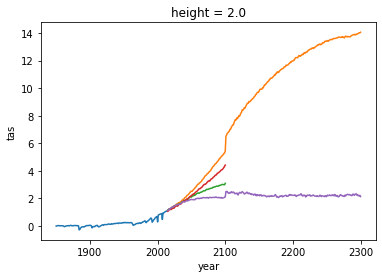

In [15]:
for exp in ['historical','ssp585','ssp245','ssp370','ssp126']:
  gm_anom_tas[exp].mean('source_id').plot()

/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


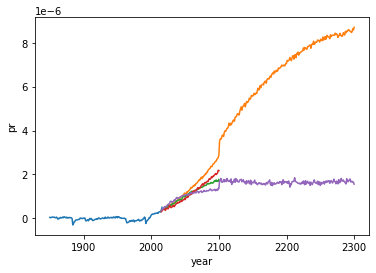

In [16]:
for exp in ['historical','ssp585','ssp245','ssp370','ssp126']:
  gm_anom_pr[exp].mean('source_id').plot()

### **Regional means**
install region mask. Regionmask is library for masking based on regions https://regionmask.readthedocs.io/en/stable/

In [17]:
!pip install regionmask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We can use region mask to mask data based on AR6 regions



In [19]:
import regionmask
import cartopy.crs as ccrs


In [20]:
def maskRegion(ds,region):
        land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(ds) #land mask
        ds=ds.where(land_mask==0) #apply mask
        ar6_land=regionmask.defined_regions.ar6.land.mask(ds) #AR6 region mask
        return ds.where(ar6_land == region)
        

In [21]:
regions={'RAR':28} #list of regions and correspoding
ds=dsall_tas['ssp126']['GFDL-ESM4'].isel(time=0)
ds = maskRegion(ds,28)
ds

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 288, bnds: 2)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 2.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    time       object 2015-01-16 12:00:00
    time_bnds  (bnds) object dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    tas        (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tas
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/bc62ce2f-5903-457c-b9e9-13d52cc3649d
    version_id:             v20180701

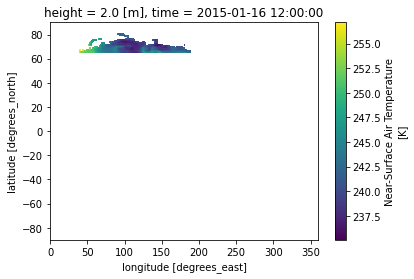

In [22]:
#proj = ccrs.PlateCarree()
#ax = plt.subplot(111, projection=proj)
ds.tas.plot()
#ax.coastlines()